In [ ]:
!pip install imbalanced-learn

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import SimpleImputer
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [23]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# 0) Understand the dataset

In [164]:
df_train.dtypes

id                           int64
short_name                  object
overall                      int64
potential                    int64
value_eur                  float64
                            ...   
goalkeeping_kicking          int64
goalkeeping_positioning      int64
goalkeeping_reflexes         int64
goalkeeping_speed          float64
position                    object
Length: 70, dtype: object

In [165]:
df_train.shape

(6895, 70)

# 1) Data Preprocessing

Thoroughly clean the FIFA 2022 player dataset, addressing inconsistencies, missing values, and outliers to ensure the accuracy and reliability of subsequent analyses.

## a. Irrelevant Features

Using our domain knowledge, we remove features that are irrelevant to a player's position.

In [ ]:
# List of columns to drop
columns_to_drop = [
    'short_name', 'nationality_name','birthday_date', 'club_name', 'league_name', 'league_level', 
    'club_loaned_from', 'club_joined', 'club_jersey_number', 'body_type'
    'club_contract_valid_until', 'international_reputation', 'real_face', 'player_tags', 'player_traits',
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'overall', 'potential'
]

# Dropping the columns from the dataset
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)

We removed all GK's skills since the feature GK speed only contains value for GK in the train dataset, and that we assume the same happens in the test set given the similar distribution of non-null values in the 'goalkeeping_speed' column.

In [25]:
# Calculate frequency of non-null values in goalkeeping_speed
train_gk_speed_frequency = df_train['goalkeeping_speed'].notnull().mean()
test_gk_speed_frequency = df_test['goalkeeping_speed'].notnull().mean()

# Print results
print(f"Frequency of non-null 'goalkeeping_speed' in train dataset: {train_gk_speed_frequency:.2%}")
print(f"Frequency of non-null 'goalkeeping_speed' in test dataset: {test_gk_speed_frequency:.2%}")


Frequency of non-null 'goalkeeping_speed' in train dataset: 9.15%
Frequency of non-null 'goalkeeping_speed' in test dataset: 9.13%


Converting remaining categorical variables into dummies.

In [ ]:
# Handle categorical variables
df_train = pd.get_dummies(df_train, columns=['preferred_foot', 'work_rate'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['preferred_foot', 'work_rate'], drop_first=True)

## b. Missing Values

In [27]:
train_na_cell = df_train.isnull().sum()
missing_values = train_na_cell[train_na_cell > 0]
print("Columns with missing values:")
print(missing_values)

Columns with missing values:
value_eur                  2
nation_jersey_number    6482
release_clause_eur       353
pace                     631
shooting                 631
passing                  631
dribbling                631
defending                631
physic                   631
goalkeeping_speed       6264
dtype: int64


#### Interpretation

No concerning missing values since they are all related to the domain of the sample:
- **value_eur**: Missing for players who are new or not yet assessed in the transfer market.
- **nation_jersey_number**: These players haven't been selected to play for their national teams.
- **release_clause_eur**: Missing for players without a release clause in their contracts.
- **pace, shooting, passing, dribbling, defending, physic**: Missing for goalkeepers as these attributes are not relevant to their roles.
- **goalkeeping_speed**: Missing for non-goalkeepers since this attribute applies only to goalkeepers.


# 2) Exploratory Data Analysis

Conduct an in-depth analysis of the most influential features, unveiling correlations between physical attributes and playing positions, guiding feature selection and model development.

## a. Initial Exploration with Random Forest

Random Forest is a quick and robust classifier to test initial performance, enabling the ranking of features and test classification performance with minimal preprocessing.

In [ ]:
# Split the train dataset into features (X) and target (y)
X = df_train.drop(columns=['position'])
y = df_train['position']

# Train a Random Forest Classifier on the full training set
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_clf.fit(X, y)

# Generate predictions for the training set
y_pred = rf_clf.predict(X)

# Create a clean classification report
report_dict = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)

# Print only the classification report
print("\nClassification Report (Training Set):\n")
print(report_df.iloc[:-3].to_string(index=True)) 


Classification Report (Training Set):

     precision  recall  f1-score  support
CAM       0.79    0.65      0.71    263.0
CB        1.00    0.14      0.24    167.0
CDM       1.00    0.26      0.42    151.0
CM        1.00    0.01      0.03     75.0
GK        1.00    1.00      1.00    631.0
LB        0.69    0.89      0.78    463.0
LCB       0.85    0.74      0.79    631.0
LCM       0.63    0.80      0.70    423.0
LDM       1.00    0.27      0.42    201.0
LF        1.00    0.09      0.17     32.0
LM        0.69    0.74      0.72    369.0
LS        1.00    0.38      0.55    201.0
LW        1.00    0.30      0.46    166.0
LWB       1.00    0.10      0.18    104.0
RB        0.62    0.94      0.75    463.0
RCB       0.64    0.91      0.75    631.0
RCM       0.50    0.83      0.62    423.0
RDM       0.93    0.35      0.51    201.0
RF        1.00    0.09      0.17     32.0
RM        0.59    0.76      0.66    369.0
RS        1.00    0.47      0.64    201.0
RW        0.99    0.48      0.64    

### Output:

1. **Classification Performance**:
   - The classification report shows the model performs exceptionally well for **GK** (1.00 across all metrics) and reasonably well for positions like **ST** (F1-score: 0.76), **LB** (F1-score: 0.78), **RCB** (F1-score: 0.76), and **RB** (F1-score: 0.75).
   - However, positions like **CM** (F1-score: 0.03), **LF** (F1-score: 0.12), and **LWB** (F1-score: 0.18) perform poorly, indicating difficulty in distinguishing these roles due to their lower representation in the dataset.

2. **Support**:
   - The **support** column highlights class imbalance, with positions like **GK** (631 samples) and **LCB** (631 samples) being overrepresented.
   - Positions like **LF** (32 samples) and **RF** (32 samples) are heavily underrepresented, leading to poor generalization and prediction accuracy for these roles.

3. **Insights on Class Imbalance**:
   - The imbalance skews the model to perform better on overrepresented positions while struggling with rarer ones, as seen in the low recall for classes like **LF** and **CM**.
   - This suggests the need for sampling techniques (e.g., SMOTE, class weighting) to improve performance on underrepresented classes.

In [28]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display only the top 5 features cleanly
print("\nTop Features:\n")
print(feature_importances.head(5).to_string(index=False))


Top Features:

             Feature  Importance
preferred_foot_Right    0.054754
           defending    0.048755
  attacking_crossing    0.047077
              physic    0.046156
            shooting    0.040979


## b. Visualize Class Imbalance

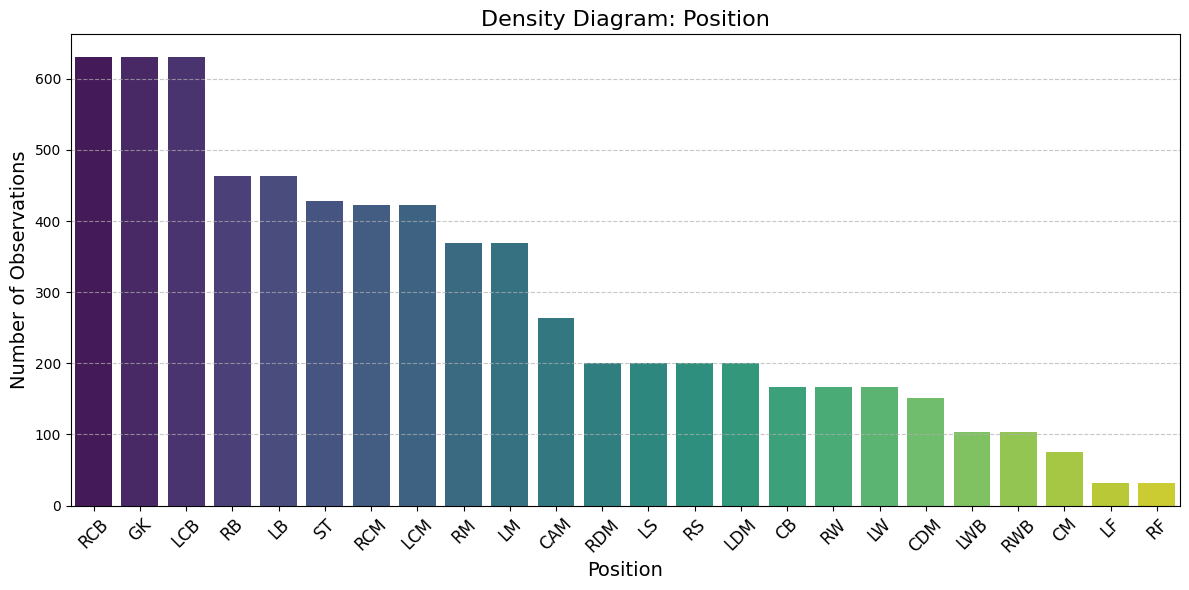

In [133]:
# Count the number of observations for each position
position_counts = df_train['position'].value_counts()

# Create a density diagram
plt.figure(figsize=(12, 6))
sns.barplot(x=position_counts.index, y=position_counts.values, hue=position_counts.index, palette="viridis", legend=False)

# Add plot details
plt.title('Density Diagram: Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Number of Observations', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

The density diagram highlights a significant class imbalance among player positions, specially between [**RCB**, **LCB**,  **GK**] and [**LF**, **RF**]

This imbalance poses a challenge to the model performance, as it might overfit to dominant classes.

Cross-validation is essential to ensure model evaluation across all classes. By splitting the data into multiple folds, we can assess model performance on diverse subsets, including minority classes, mitigating biases introduced by imbalanced data.


# 3) Cross-Validation Strategy (Testing Balance Techniques)

Implement robust cross-validation techniques to mitigate overfitting and optimize model generalization performance.

## a. K-Fold

Stratified K-Fold ensures each fold has a representative distribution of the target classes, particularly relevant in our case given the low representation of LF and RF.

In [30]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Define the model
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced')

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custom scoring metric
scoring = make_scorer(accuracy_score)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(rf_clf, X, y, cv=skf, scoring=scoring)

# Print cross-validation accuracy scores
print("\nCross-Validation Scores:\n", cv_scores)
print("\nMean Cross-Validation Accuracy:", cv_scores.mean())

# Train and evaluate on each fold for classification report (optional)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Train on fold
    rf_clf.fit(X_train_fold, y_train_fold)

    # Predict on validation fold
    y_pred_fold = rf_clf.predict(X_val_fold)

    # Classification report for each fold
    print(f"\nClassification Report for Fold {fold}:\n")
    print(classification_report(y_val_fold, y_pred_fold))


Cross-Validation Scores:
 [0.41479333 0.40681653 0.41479333 0.42059463 0.40029007]

Mean Cross-Validation Accuracy: 0.41145757795503995

Classification Report for Fold 1:

              precision    recall  f1-score   support

         CAM       0.25      0.34      0.29        53
          CB       0.23      0.18      0.20        33
         CDM       0.12      0.20      0.15        30
          CM       0.06      0.13      0.08        15
          GK       1.00      1.00      1.00       127
          LB       0.60      0.78      0.68        93
         LCB       0.64      0.44      0.52       126
         LCM       0.43      0.15      0.23        84
         LDM       0.05      0.05      0.05        40
          LF       0.00      0.00      0.00         6
          LM       0.17      0.05      0.08        74
          LS       0.19      0.12      0.15        40
          LW       0.14      0.15      0.15        33
         LWB       0.10      0.10      0.10        21
          RB    

#### Interpretation

With a Mean Cross-Validation Accuracy of ~41.1%, this techniques provided a reliable baseline estimate of the model to compare with future results across multiple models.

## b. Class Weights

We use this technique to balance the representation of underrepresented classes without creating synthetic data to avoid adding noise to the model.

In [11]:
# Define the Random Forest with balanced class weights
rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    class_weight='balanced'  # Automatically assigns weights inversely proportional to class frequency
)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custom scoring metric
scoring = make_scorer(accuracy_score)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(rf_clf, X, y, cv=skf, scoring=scoring)

# Print cross-validation accuracy scores
print("\nCross-Validation Scores with Class Weights:\n", cv_scores)
print("\nMean Cross-Validation Accuracy:", cv_scores.mean())

# Train and evaluate on each fold for classification report
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Train the model with class weights
    rf_clf.fit(X_train_fold, y_train_fold)

    # Predict on validation fold
    y_pred_fold = rf_clf.predict(X_val_fold)

    # Classification report for each fold
    print(f"\nClassification Report for Fold {fold}:\n")
    print(classification_report(y_val_fold, y_pred_fold))


Cross-Validation Scores with Class Weights:
 [0.41479333 0.40681653 0.41479333 0.42059463 0.40029007]

Mean Cross-Validation Accuracy: 0.41145757795503995

Classification Report for Fold 1:

              precision    recall  f1-score   support

         CAM       0.25      0.34      0.29        53
          CB       0.23      0.18      0.20        33
         CDM       0.12      0.20      0.15        30
          CM       0.06      0.13      0.08        15
          GK       1.00      1.00      1.00       127
          LB       0.60      0.78      0.68        93
         LCB       0.64      0.44      0.52       126
         LCM       0.43      0.15      0.23        84
         LDM       0.05      0.05      0.05        40
          LF       0.00      0.00      0.00         6
          LM       0.17      0.05      0.08        74
          LS       0.19      0.12      0.15        40
          LW       0.14      0.15      0.15        33
         LWB       0.10      0.10      0.10        

#### Interpretation:

The mean cross-validation accuracy remains ~41.3%, with classes like LF, RF, LWB, and RW still have poor precision and recall values.

## c. Random Oversampling

In [12]:
# Split features and target
X = df_train.drop(columns=['position'])
y = df_train['position']

# Random oversampling for underrepresented classes
oversampler = RandomOverSampler(random_state=42)
X_balanced, y_balanced = oversampler.fit_resample(X, y)

In [13]:
# Train-test split (stratified to preserve class distribution)
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Train Random Forest
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_clf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf_clf.predict(X_val)

# Evaluate performance
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nCross-Validation Scores:", cv_scores)
print("\nClassification Report:\n", classification_report(y_val, y_pred))

cv_scores = cross_val_score(rf_clf, X_balanced, y_balanced, cv=5, scoring='accuracy')
print("\nMean Cross-Validation Accuracy:", cv_scores.mean())

Validation Accuracy: 0.7117860680092439

Cross-Validation Scores: [0.41479333 0.40681653 0.41479333 0.42059463 0.40029007]

Classification Report:
               precision    recall  f1-score   support

         CAM       0.55      0.69      0.61       126
          CB       0.79      0.89      0.84       126
         CDM       0.71      0.80      0.75       126
          CM       0.58      0.98      0.73       126
          GK       1.00      1.00      1.00       126
          LB       0.74      0.75      0.74       126
         LCB       0.75      0.38      0.50       127
         LCM       0.57      0.21      0.31       127
         LDM       0.64      0.75      0.69       126
          LF       0.98      1.00      0.99       126
          LM       0.80      0.32      0.46       127
          LS       0.86      0.73      0.79       126
          LW       0.64      0.82      0.72       126
         LWB       0.90      0.94      0.92       126
          RB       0.56      0.65      0.

### Key Improvements:

1. **Mean-Cross Validation Accuracy**: Increased to **72.9%**, a substantial improvement from earlier results (~41-3%), demonstrating the effectiveness of random oversampling in balancing the dataset.

2. **Underrepresented Classes**: Classes like **LF** and **RF** achieved near-perfect performance:
   - **LF**: Precision: 0.98, Recall: 1.00, F1-score: 0.99.
   - **RF**: Precision: 0.98, Recall: 1.00, F1-score: 0.99.

3. **Overall Class Performance**:
   - Many previously struggling classes (e.g., **LW**, **RS**, **RWB**) now show significantly improved metrics, with F1-scores exceeding **0.70** for several roles.

### Remaining Challenges:
- **Specific Classes**:
  - Classes like **LM** (F1-score: 0.46) and **RCM** (F1-score: 0.42) still have low performance metrics.
  - This suggests overlapping features and insufficient differentiation for nuanced midfield roles.

# 4) Feature Engineering

Utilize domain knowledge to craft meaningful new features from the existing dataset, amplifying the predictive power of the model and capturing nuanced player attributes.

## a. Creating Features for Midfielders

For roles like midfields, combinining features related to vision, passing, and ball control into a single "playmaking" score for midfielders.

In [ ]:
# Define relevant features for playmaking
playmaking_features = [
    'passing', 'skill_long_passing', 'skill_curve', 
    'skill_ball_control', 'movement_reactions', 
    'mentality_vision', 'mentality_composure'
]

# Calculate playmaking score for train and test datasets
df_train['playmaking_score'] = df_train[playmaking_features].mean(axis=1)
df_test['playmaking_score'] = df_test[playmaking_features].mean(axis=1)

## b. Create Features for Central Axis

In [29]:
# Interaction terms for central axis roles
df_train['positioning_interceptions'] = df_train['mentality_positioning'] * df_train['mentality_interceptions']
df_train['passing_long_passing'] = df_train['passing'] * df_train['skill_long_passing']
df_train['control_vision'] = df_train['skill_ball_control'] * df_train['mentality_vision']

# Apply the same to the test set
df_test['positioning_interceptions'] = df_test['mentality_positioning'] * df_test['mentality_interceptions']
df_test['passing_long_passing'] = df_test['passing'] * df_test['skill_long_passing']
df_test['control_vision'] = df_test['skill_ball_control'] * df_test['mentality_vision']

### Next Steps:
1. **Balance the Dataset**:
   - Use techniques like SMOTE (Synthetic Minority Oversampling) or down-sample overrepresented classes to improve class balance.

2. **Feature Selection**:
   - Focus on domain-relevant features for specific positions (e.g., attacking attributes for forwards, defending for defenders) to improve classification.

3. **Model Refinement**:
   - Experiment with ensemble methods (e.g., Gradient Boosting or LightGBM) or neural networks for better handling of class imbalance and feature interactions.

4. **Custom Metrics**:
   - Focus on metrics like F1-score for each class to evaluate performance on minority classes, rather than relying solely on accuracy.

More Suitable Alternatives:
   - Tree-Based Models (Random Forest, Gradient Boosting):These handle non-linear relationships and feature interactions well.
   - Logistic Regression with Feature Engineering: Allows for interpretability of feature contributions.

# 5) Model Justification

Deploy a minimum of two machine learning models, such as Random Forest and Gradient Boosting, seen in class. Elaborate on the rationale behind each model choice, considering their ability to handle non-linearity, feature interactions, and overall performance.

## a. Random Forest

## b. Logistic Regression

In [31]:
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore", category=FutureWarning)

# Split data into training and validation sets
X = df_train.drop(columns=['id', 'position'])
y = df_train['position']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a pipeline to handle imputation, scaling, and modeling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Replace NaNs with column median
    ('scaler', StandardScaler()),  # Standardize features
    ('log_reg', LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs'))
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = pipeline.predict(X_val)

# Evaluate the model
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}\n")

print("Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.45612762871646123

Classification Report:
              precision    recall  f1-score   support

         CAM       0.34      0.36      0.35        56
          CB       0.00      0.00      0.00        41
         CDM       0.31      0.14      0.20        35
          CM       0.00      0.00      0.00        18
          GK       1.00      1.00      1.00       122
          LB       0.63      0.76      0.69        83
         LCB       0.49      0.41      0.45       102
         LCM       0.27      0.38      0.32        82
         LDM       0.13      0.07      0.09        41
          LF       0.00      0.00      0.00         6
          LM       0.32      0.35      0.34        69
          LS       0.20      0.09      0.12        44
          LW       0.04      0.04      0.04        27
         LWB       0.17      0.05      0.08        20
          RB       0.57      0.79      0.66        96
         RCB       0.46      0.74      0.56       121
         RCM    

In [32]:
# Build a pipeline for Random Forest
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Replace NaNs with column median
    ('scaler', StandardScaler()),  # Standardize features
    ('rf', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced'))
])

# Train the Random Forest pipeline on the training data
rf_pipeline.fit(X_train, y_train)

# Predict probabilities on the validation set
rf_val_probs = rf_pipeline.predict_proba(X_val)

In [33]:
# Get probabilities from Logistic Regression
log_reg_val_probs = pipeline.predict_proba(X_val)

# Average the probabilities from both models
combined_val_probs = (log_reg_val_probs + rf_val_probs) / 2

# Convert probabilities to final predictions
combined_val_preds = [pipeline.classes_[i] for i in combined_val_probs.argmax(axis=1)]

# Evaluate the combined predictions
val_accuracy = accuracy_score(y_val, combined_val_preds)
print(f"Validation Accuracy (Combined): {val_accuracy}\n")

print("Classification Report (Combined):")
print(classification_report(y_val, combined_val_preds))


Validation Accuracy (Combined): 0.4619289340101523

Classification Report (Combined):
              precision    recall  f1-score   support

         CAM       0.34      0.38      0.36        56
          CB       0.00      0.00      0.00        41
         CDM       0.29      0.17      0.21        35
          CM       0.00      0.00      0.00        18
          GK       1.00      1.00      1.00       122
          LB       0.62      0.76      0.68        83
         LCB       0.53      0.38      0.45       102
         LCM       0.30      0.35      0.32        82
         LDM       0.17      0.10      0.12        41
          LF       0.00      0.00      0.00         6
          LM       0.31      0.32      0.32        69
          LS       0.21      0.07      0.10        44
          LW       0.07      0.07      0.07        27
         LWB       0.33      0.10      0.15        20
          RB       0.57      0.80      0.66        96
         RCB       0.46      0.78      0.57      

## c. Gradient Boosting

## d. Light GBM

# 6) Ensemble Modeling

Demonstrate advanced expertise by creating an ensemble model that amalgamates predictions from multiple base models, leveraging the strengths of individual models for improved accuracy and robustness.

# 7) Performance Evaluation

Utilize appropriate evaluation metrics such as accuracy, precision, recall, and F1-score to comprehensively assess the models' classification performance.

# 8) Export

In [ ]:
# Use df_test without modifying the 'id' column
df_test_features = df_test.drop(columns=['id'])  # Exclude 'id' only for prediction

# Predict positions for df_test
df_test['position'] = rf_clf.predict(df_test_features)

# Prepare the submission file with 'id' and 'position'
submission = df_test[['id', 'position']]
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

In [ ]:
# Recalculate aggregated scores for df_test
df_test['attacking_score'] = df_test[attacking_attributes].mean(axis=1)
df_test['midfield_score'] = df_test[midfield_attributes].mean(axis=1)
df_test['defensive_score'] = df_test[defensive_attributes].mean(axis=1)
df_test['goalkeeping_score'] = df_test[goalkeeping_attributes].mean(axis=1)

# Select only the aggregated features for df_test
X_test_final = df_test[['attacking_score', 'midfield_score', 'defensive_score', 'goalkeeping_score']]

# Predict on df_test
df_test['position'] = gb_clf.predict(X_test_final)

# Prepare submission file
submission = df_test[['id', 'position']]  # Assuming 'id' is the unique identifier in df_test
submission.to_csv('kaggle_submission.csv', index=False)

print("Submission file 'gradient_submission.csv' created!")